- Se simplifican concentraciones de iones y la presencia de las vainas

1. Alfa
2. m, n y h
3. Valores

No hay valores iniciales de m, n y h hay que encontrarlos a partir del potencial de reposo calcular alphas y betas e igualar las derivaadas a cero para encontrar m, n y h.

Teniendo el modelo corriendo hay que estimular con un impulso de corriente de 15 y que dure 1ms

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

gNa_cte = 120.0 #ms/cm²
gK_cte = 36.0
gL_cte = 0.3
ENa = 45.0 #mV
EK = 82.0
EL = 59.0
C_m = 1.0 #\muAms/cm²


def alpha_m(V):
	return ((V+45.0)/10.0)/(1.0-np.e**(-1.0*(V+45.0)/10.0))

def alpha_h(V):
	return 0.07 * np.e**(-1.0*(V+70.0)/20.0)

def alpha_n(V):
	return ((V+60.0)/100.0)/(1.0-np.e**(-1.0*(V+60.0)/10.0))

def beta_m(V):
	return 4.0*np.e**(-1.0*(V+70.0)/18.0)

def beta_h(V):
	return 1.0/(1.0+np.e**(-1.0*(V+40.0)/10.0))

def beta_n(V):
	return 0.125*np.e**(-1.0*(V+70.0)/80.0)


def dm_dt(V, m):
	return alpha_m(V)*(1.0-m)-beta_m(V)*m

def dh_dt(V, h):
	return alpha_h(V)*(1.0-h)-beta_h(V)*h

def dn_dt(V, n):
	return alpha_n(V)*(1.0-n)-beta_n(V)*n

def gNa(m, h):
	return gNa_cte*(m**3)*h

def gK(n):
	return gK_cte*(n**4)

def g(gNa, gK, gL):
	return gNa + gK + gL

def Em(gNa, gK, gL):
	return (gNa*ENa + gK * EK + gL * EL) / (gNa + gK + gL)

# def dv_dt(I, v, gK, gNa, gL):
# 	return (I - gK * (v - EK) - gNa * (v - ENa) - gL * (v - EL)) / C_m


def dv_dt(I, v, gK, gNa, gL):
	return I - g(gNa, gK, gL) * (v - Em(gNa, gK, gL)) / C_m

In [2]:
pot_reposo = -70.0

alpha_m_0 = alpha_m(pot_reposo)
alpha_h_0 = alpha_h(pot_reposo)
alpha_n_0 = alpha_n(pot_reposo)

print()
beta_m_0 = beta_m(pot_reposo)
beta_h_0 = beta_h(pot_reposo)
beta_n_0 = beta_n(pot_reposo)

m_sp = sp.Symbol('m')
m_0 = sp.solve(sp.Eq(alpha_m_0*(1-m_sp)-beta_m_0*m_sp, 0))[0]
h_sp = sp.Symbol('h')
h_0 = sp.solve(sp.Eq(alpha_h_0*(1-h_sp)-beta_h_0*h_sp, 0))[0]
n_sp = sp.Symbol('n')
n_0 = sp.solve(sp.Eq(alpha_n_0*(1-n_sp)-beta_n_0*n_sp, 0))[0]

print(f"m(0)={m_0}\nn(0)={n_0}\nh(0)={h_0}")



m(0)=0.0529324852572496
n(0)=0.317676914060697
h(0)=0.596120753508459


In [9]:
def euler(ts, m_0, h_0, n_0, v_0, I_s):
	dt = ts[1] - ts[0]
	
	v_s = [v_0]
	m_s = [m_0]
	h_s = [h_0]
	n_s = [n_0]
	# print(f"m(0)={m_0}\nn(0)={n_0}\nh(0)={h_0}")
	gNa_s = [gNa(m_s[-1], h_s[-1])]
	gK_s = [gK(n_s[-1])]
	gL = gL_cte
	
	print(f"gNa(0)={gNa_s[0]}\ngK(0)={gK_s[0]}\ngL={gL_cte}")
	for i in range(len(ts[1:])):
		v = v_s[-1]
		m = m_s[-1]
		n = n_s[-1]
		h = h_s[-1]
		m_s.append(m + dt * dm_dt(v, m))
		n_s.append(n + dt * dn_dt(v, n))
		h_s.append(h + dt * dh_dt(v, h))


		m = m_s[-1]
		n = n_s[-1]
		h = h_s[-1]
		gNa_s.append(gNa(m, h))
		gK_s.append(gK(n))

		I = I_s[i+1]

		v_s.append(v + dt * dv_dt(I, v, gK_s[-1], gNa_s[-1], gL))

	return v_s, gNa_s, gK_s, m_s, n_s, h_s

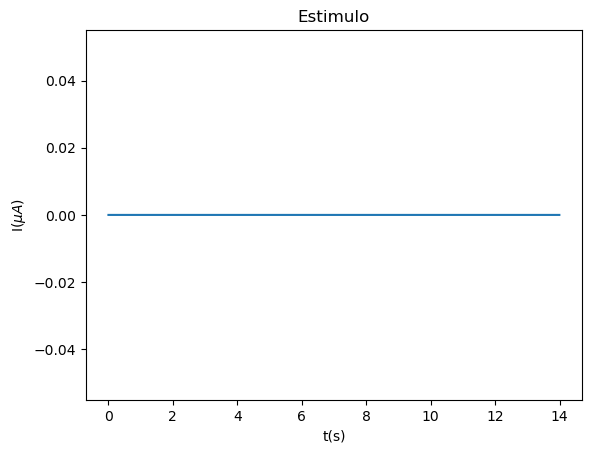

gNa(0)=0.0106091928388298
gK(0)=0.366644455606907
gL=0.3


In [10]:
paso = 0.01
ts = np.arange(0, 14, paso)
I_s = [0 for i in ts]
# I_s[int(5/paso):int(6/paso)] = [0.000015] * len(I_s[int(5/paso):int(6/paso)])
# I_s[:int(1/paso)] = [0.000015] * len(I_s[:int(1/paso)])
plt.title("Estimulo")
plt.plot(ts, I_s)
plt.ylabel(r"I$(\mu A)$")
plt.xlabel("t(s)")
plt.show()
v_s, gNa_s, gK_s, m_s, n_s, h_s = euler(ts, m_0, h_0, n_0, pot_reposo, I_s)

In [12]:
print(v_s[1])

-69.0434998557129


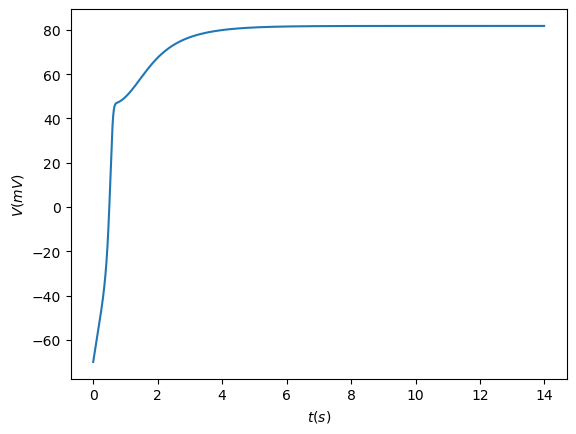

In [11]:
plt.plot(ts, v_s)
plt.ylabel(r"$V(mV)$")
plt.xlabel(r"$t(s)$")
# plt.ylim(-70, 50)
plt.show()
# plt.plot(ts, I_s)
# plt.plot(ts, gNa_s)
# plt.plot(ts, gK_s)

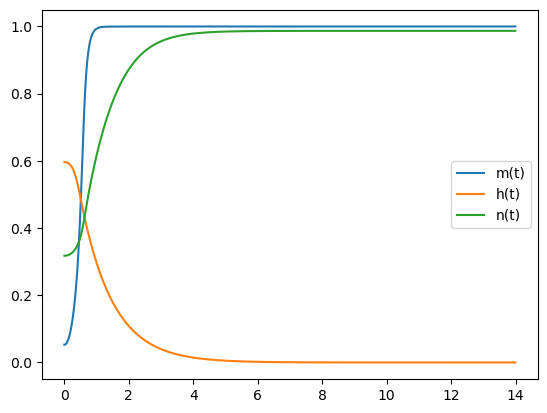

In [6]:
plt.plot(ts, m_s, label="m(t)")
plt.plot(ts, h_s, label="h(t)")
plt.plot(ts, n_s, label="n(t)")

plt.legend()